In [ ]:
!pip install numpy matplotlib pillow --quiet
!pip install torch transformers diffusers --quiet
!pip install ftfy --quiet

!wget https://github.com/TencentARC/GFPGAN/releases/download/v1.3.0/GFPGANv1.3.pth -P experiments/pretrained_models --quiet
!wget https://raw.githubusercontent.com/TencentARC/GFPGAN/master/inference_gfpgan.py  --quiet
!pip install basicsr facexlib realesrgan --quiet

In [ ]:
# import libs
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from pathlib import Path

In [ ]:
!nvidia-smi

Thu Sep 22 23:13:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Initial generation
Enter your token below to load the weights from HuggingFace

In [ ]:
# set authentication token for HuggingFace
access_token = ""

# load model
model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"
pipe = StableDiffusionPipeline.from_pretrained(model_id, use_auth_token=access_token)
pipe = pipe.to(device)

{'trained_betas'} was not found in config. Values will be initialized to default values.


In [ ]:
# set params 
# begin with 1:1 aspect ratio, use 512x512 only
width = 512
height = int(width * 5 / 4)
# 50 or 100 
num_steps = 100
# 7.5 or 15
scale = 15

# set prompt attributes

# TRY MODIFYING THESE
character = "majestic sun-sprite"
style_modifiers = ["intricate details", "shiny"]

# RECOMMENDED: DO NOT MODIFY QUALITY MODIFIERS
quality_modifiers = ["fashion photoshoot", "hyperrealistic"]

# construct prompt
prompt = "close-up portrait of a {}".format(character)
prompt += ", " + ", ".join(quality_modifiers)
prompt += ", " + ", ".join(style_modifiers)

prompt

'close-up portrait of a majestic sun-sprite, fashion photoshoot, hyperrealistic, intricate details, shiny'

  0%|          | 0/101 [00:00<?, ?it/s]

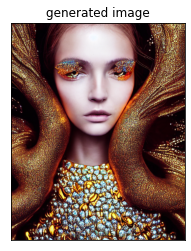

In [ ]:
# diffuse and show results (1 samples)
# do not change in colab (Colab will only let us do 1 sample)
num_samples = 1 

with autocast("cuda"):
    out_dict = pipe([prompt] * num_samples, 
                    width=width, 
                    height=height, 
                    guidance_scale=scale,
                    num_inference_steps=num_steps)
    
images_out = out_dict["sample"]

if len(images_out) > 1:
    fig, axes = plt.subplots(2, 2, figsize=(8,8))
    for idx, (im, ax) in enumerate(zip(images_out, axes.flatten())):
        ax.imshow(im)
        ax.set_title(idx)
        ax.set_xticks([])
        ax.set_yticks([])
    print("\t\t     generated images")
else:
    plt.imshow(images_out[0])
    plt.title("generated image")
    plt.xticks([])
    plt.yticks([])

plt.show()

In [ ]:
# select image to continue with
idx_selected = 0

image_11 = images_out[idx_selected]

file_name = "temp" # if you change this file name make sure to update it below when running GFPGAN

Path("./images_out/").mkdir(exist_ok=True)

image_11.save("images_out/{}.png".format(file_name))

# clean up GPU before upscaling
del pipe
torch.cuda.empty_cache()

### Upscaling

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Processing temp.png ...
	Tile 1/4
	Tile 2/4
	Tile 3/4
	Tile 4/4
Results are in the [results] folder.


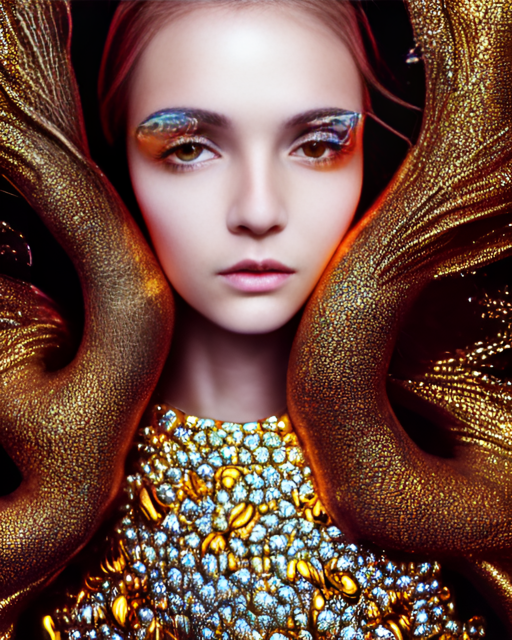

In [ ]:
!python3 inference_gfpgan.py -i images_out/temp.png -o results -v 1.3 -s 4

torch.cuda.empty_cache()

# resizing just to show cleanly in the notebook
Image.open("./results/restored_imgs/{}.png".format("temp")).resize((512, 640))

---